# Projeto de Machine Learning Aplicado à Prioritização de Investimentos em UBS

## Introdução
Este trabalho tem como objetivo aplicar técnicas de Machine Learning para apoiar a priorização de investimentos em infraestrutura de Unidades Básicas de Saúde (UBS) nos municípios de Minas Gerais. A motivação do estudo está relacionada à necessidade de tornar mais transparentes, reprodutíveis e baseadas em evidências as decisões de alocação de recursos públicos em saúde.

O projeto está alinhado ao tema do Trabalho de Conclusão de Curso (TCC), que discute desigualdades socioespaciais, vulnerabilidade social e eficiência da Atenção Primária à Saúde (APS).

## Definição do Problema e Objetivo
Problema: como identificar, de forma sistemática e transparente, quais municípios apresentam maior prioridade para investimentos em infraestrutura de UBS?

Objetivo geral: construir um modelo de Machine Learning capaz de classificar os municípios de Minas Gerais em níveis de prioridade (Baixa, Média e Alta), com base em indicadores socioeconômicos, demográficos e de saúde.

Unidade de análise: município
Escopo temporal: Dados de população, óbitos e UBS de 2022, Dado do IVS de 2010
Área geográfica: Minas Gerais


## Carregamento e inspeção inicial dos dados

In [80]:
import pandas as pd


df = pd.read_excel("dataset_mun_MG.xlsx")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   IBGE7                               853 non-null    int64  
 1   ivs                                 853 non-null    float64
 2   idhm                                853 non-null    float64
 3   prosp_soc                           853 non-null    int64  
 4   espvida                             853 non-null    float64
 5   renda_per_capita                    853 non-null    float64
 6   i_gini                              853 non-null    float64
 7   pop_2022                            853 non-null    int64  
 8   densidade_demografica_pop_km2_2022  853 non-null    float64
 9   obitos_total_2022                   853 non-null    int64  
 10  obitos_icsap_2022                   853 non-null    int64  
 11  qtd_ubs_mun_2022                    853 non-n

,IBGE7,ivs,idhm,prosp_soc,espvida,renda_per_capita,i_gini,pop_2022,densidade_demografica_pop_km2_2022,obitos_total_2022,obitos_icsap_2022,qtd_ubs_mun_2022
0,3100104,0.232,0.689,2,75.35,596.18,0.47,6272,7.12,66,17,2
1,3100203,0.290,0.698,2,75.90,707.24,0.54,22675,12.48,223,62,6
2,3100302,0.282,0.654,2,74.36,444.32,0.52,13927,29.60,125,46,7
3,3100401,0.335,0.630,3,74.36,357.03,0.48,3909,38.37,30,9,3
4,3100500,0.571,0.610,4,75.66,325.42,0.48,8943,10.97,71,31,6


In [81]:
#Verificando valores nulos e/ou duplicados
df.isna().sum().sort_values(ascending=False)
df.duplicated("IBGE7").sum()

np.int64(0)

In [82]:
m = df.shape[0]
m

853

In [83]:
df["IBGE7"] = df["IBGE7"].astype(str).str.zfill(7)

## Análise exploratória dos dados

Foram utilizadas estatísticas descritivas e visualizações gráficas para compreender a distribuição das variáveis e identificar padrões iniciais.

In [84]:
df.describe()

,ivs,idhm,prosp_soc,espvida,renda_per_capita,i_gini,pop_2022,densidade_demografica_pop_km2_2022,obitos_total_2022,obitos_icsap_2022,qtd_ubs_mun_2022
count,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,8.530000e+02,853.000000,853.000000,853.000000,853.000000
mean,0.316018,0.667878,2.524033,74.424771,490.599742,0.473283,2.407971e+04,69.086928,190.434936,59.451348,7.155920
std,0.091333,0.049637,1.196021,1.790176,173.077762,0.053103,9.435278e+04,314.424841,727.962047,205.397780,10.177432
min,0.158000,0.529000,1.000000,68.370000,181.770000,0.320000,8.330000e+02,1.210000,6.000000,1.000000,0.000000
25%,0.243000,0.633000,2.000000,73.100000,359.930000,0.440000,4.639000e+03,12.170000,40.000000,13.000000,3.000000
50%,0.302000,0.670000,2.000000,74.410000,475.230000,0.470000,8.048000e+03,22.090000,68.000000,22.000000,4.000000
75%,0.373000,0.702000,3.000000,75.780000,592.950000,0.500000,1.728500e+04,43.760000,152.000000,49.000000,8.000000
max,0.653000,0.813000,5.000000,78.150000,1731.840000,0.780000,2.315560e+06,6988.180000,18319.000000,5052.000000,164.000000


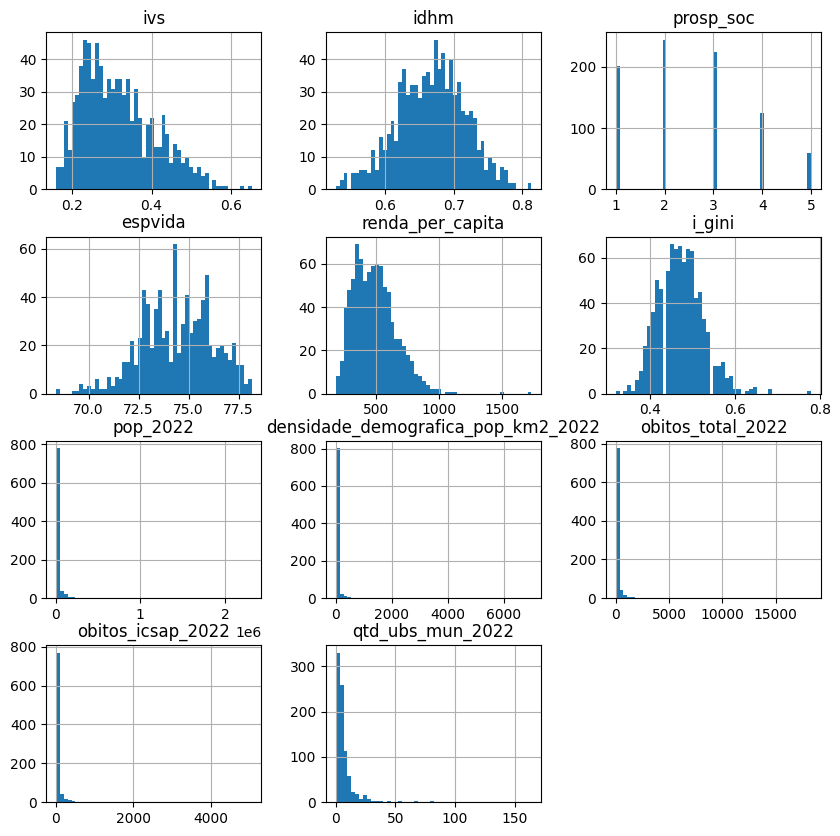

In [85]:
df.hist(bins=50, figsize=(10, 10));

## Engenharia de Variáveis

Nesta etapa, foram construídas variáveis mais informativas e comparáveis entre municípios, priorizando indicadores relativos à população.

- Taxa de óbitos por 1.000 habitantes

- Óbitos por condições sensíveis à APS (ICSAP)

- UBS por 10.000 habitantes

In [86]:
df["tx_obitos_icsap_1000"] = df["obitos_icsap_2022"] / df["pop_2022"] * 1000
df["tx_obitos_total_1000"] = df["obitos_total_2022"] / df["pop_2022"] * 1000
df["ubs_por_10000"] = df["qtd_ubs_mun_2022"] / df["pop_2022"] * 10000

## Construção do Score de Prioridade

Foi definido um score multicritério que combina indicadores de vulnerabilidade social, mortalidade evitável, desenvolvimento humano e oferta de UBS. As variáveis foram previamente normalizadas.

In [87]:
from sklearn.preprocessing import MinMaxScaler


vars_score = [
"tx_obitos_icsap_1000",
"tx_obitos_total_1000",
"ivs",
"idhm",
"i_gini",
"ubs_por_10000"
]


scaler = MinMaxScaler()
df[vars_score] = scaler.fit_transform(df[vars_score])

In [88]:
df["score_prioridade"] = (
df["tx_obitos_icsap_1000"] * 0.25 +
df["tx_obitos_total_1000"] * 0.15 +
df["ivs"] * 0.20 +
(1 - df["idhm"]) * 0.15 +
df["i_gini"] * 0.10 +
(1 - df["ubs_por_10000"]) * 0.15
)

Durante o desenvolvimento do TCC, o score_prioridade será melhor explorado, testando outros pesos e outras variáveis.

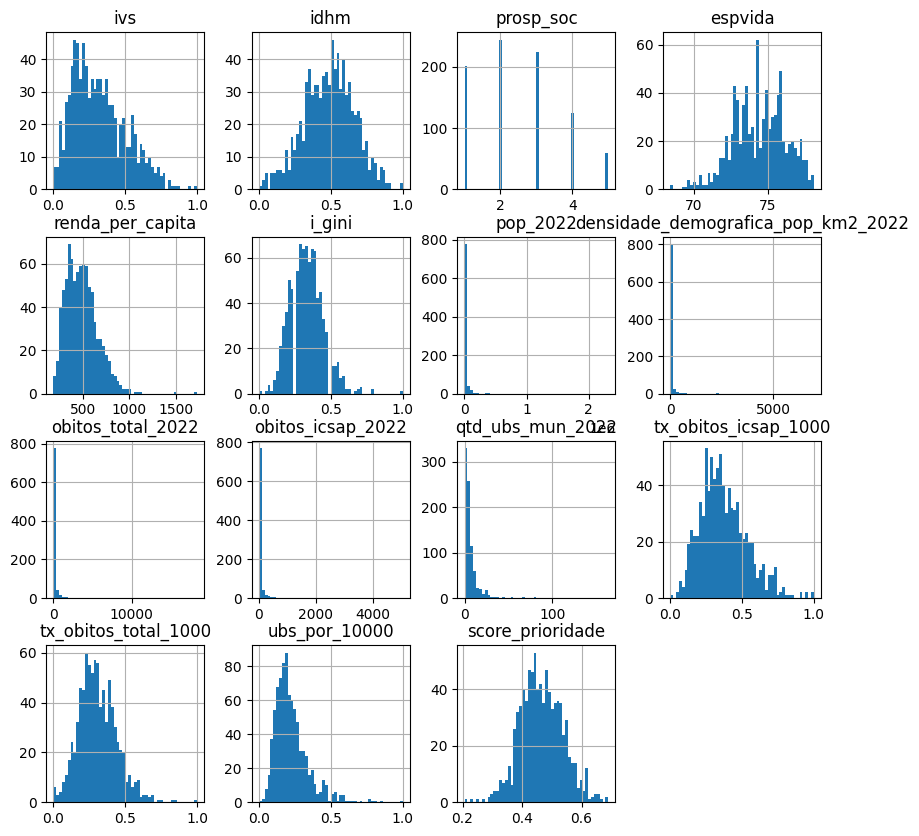

In [89]:
df_norm.hist(bins=50, figsize=(10, 10));

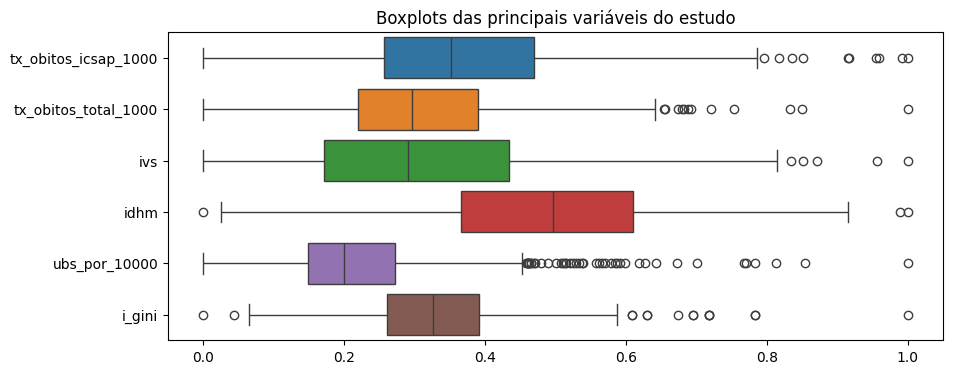

In [90]:
vars_box = [
    "tx_obitos_icsap_1000",
    "tx_obitos_total_1000",
    "ivs",
    "idhm",
    "ubs_por_10000",
    "i_gini"
]

plt.figure(figsize=(10, 4))
sns.boxplot(data=df[vars_box], orient="h")
plt.title("Boxplots das principais variáveis do estudo")
plt.show()


### Tratamento de valores extremos

A análise por meio de boxplots indicou a presença de valores extremos em algumas variáveis, especialmente nas taxas de óbitos e na oferta relativa de UBS. Esses valores não serão removidos, pois representam municípios reais com condições socioeconômicas e sanitárias mais críticas, que são justamente o foco da política pública analisada. A exclusão desses valores poderia comprometer a capacidade do modelo de identificar situações de maior vulnerabilidade territorial.


# Definição da Variável-Alvo

O score foi transformado em uma variável categórica de prioridade (Baixa, Média e Alta) por meio de quantis.

Nota metodológica: a variável-alvo é derivada do próprio score, o que implica que o modelo aprende a reproduzir um critério multicritério previamente definido.

In [91]:
df["prioridade"] = pd.qcut(
df["score_prioridade"],
q=3,
labels=["Baixa", "Media", "Alta"]
)

## Análise de Correlação e Seleção de Variáveis

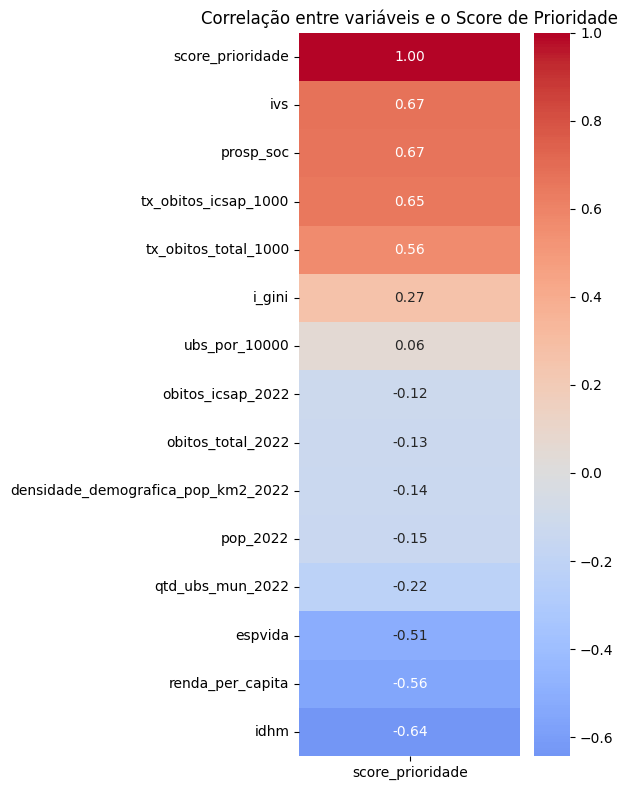

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_score = (
    df
    .corr(numeric_only=True)[["score_prioridade"]]
    .sort_values(by="score_prioridade", ascending=False)
)

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_score,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Correlação entre variáveis e o Score de Prioridade")
plt.tight_layout()
plt.show()

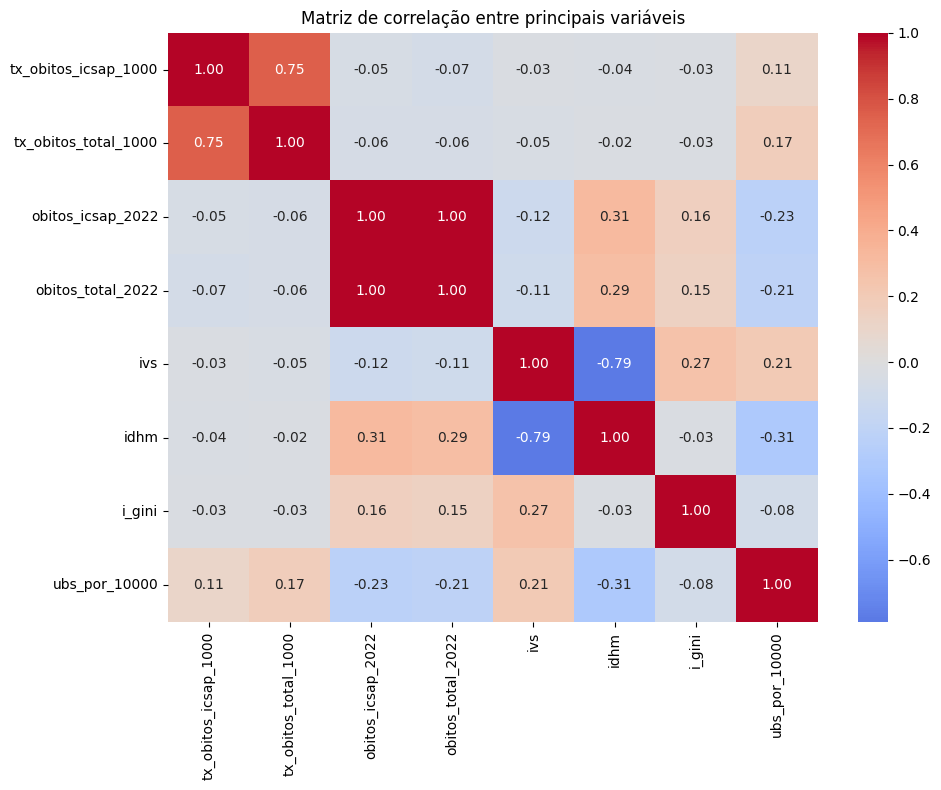

In [93]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[[
        "tx_obitos_icsap_1000",
        "tx_obitos_total_1000",
        "obitos_icsap_2022",
        "obitos_total_2022",
        "ivs",
        "idhm",
        "i_gini",
        "ubs_por_10000"
    ]].corr(),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Matriz de correlação entre principais variáveis")
plt.tight_layout()
plt.show()

### Seleção final de variáveis

*Variáveis mantidas:*

- tx_obitos_icsap_1000
- tx_obitos_total_1000
- ivs
- idhm
- i_gini
- ubs_por_10000
- espvida
- densidade_demografica_pop_km2_2022

*Variáveis removidas:*
- pop_2022 (escala populacional)
- óbitos absolutos
- renda_per_capita (redundante com IDHM)
- prosp_soc (usada apenas para estratificação - será removida após a estratificação)

## Separação Treino/Teste com Estratificação

A divisão dos dados foi realizada por amostragem estratificada com base na variável de prosperidade social, garantindo representatividade socioeconômica nos subconjuntos.

### Estratificação por prosp_soc

A divisão dos dados em conjuntos de treinamento e teste foi realizada por amostragem estratificada com base na variável de prosperidade social, de modo a preservar a distribuição dos diferentes níveis de desenvolvimento e vulnerabilidade socioespacial, reduzindo vieses de amostragem.

Significado o prosp_Soc

1	- Muito Alto - Muito bom desenvolvimento + muito baixa vulnerabilidade

2 - Alto - Bom desenvolvimento + baixa vulnerabilidade

3 - Médio - Situação intermediária

4 - Baixo - Pouco desenvolvimento + alta vulnerabilidade

5 - Muito Baixo - Baixíssimo desenvolvimento + altíssima vulnerabilidade

In [94]:
from sklearn.model_selection import train_test_split


treino, teste = train_test_split(
df,
test_size=0.2,
random_state=42,
stratify=df["prosp_soc"]
)

In [95]:
dist_total = df["prosp_soc"].value_counts(normalize=True).sort_index()
dist_treino = treino["prosp_soc"].value_counts(normalize=True).sort_index()
dist_teste = teste["prosp_soc"].value_counts(normalize=True).sort_index()

tabela_comparativa = (
    (100 * dist_total.rename("dados")).to_frame()
    .join((100 * dist_treino.rename("treino")))
    .join((100 * dist_teste.rename("teste")))
).round(2)

tabela_comparativa


,dados,treino,teste
prosp_soc,,,
1,23.68,23.75,23.39
2,28.60,28.59,28.65
3,26.26,26.25,26.32
4,14.54,14.52,14.62
5,6.92,6.89,7.02


In [96]:
treino = treino.drop(columns=["prosp_soc"])
teste  = teste.drop(columns=["prosp_soc"])

In [105]:
vars_final = [
    "tx_obitos_icsap_1000",
    "tx_obitos_total_1000",
    "ivs",
    "idhm",
    "i_gini",
    "ubs_por_10000",
    "espvida",
    "densidade_demografica_pop_km2_2022"
]

X_train = treino[vars_final]
X_test  = teste[vars_final]

y_train = treino["prioridade"]
y_test = teste["prioridade"]

## Pipeline de Modelagem

Foi construído um pipeline contendo padronização das variáveis e Regressão Logística.


In [106]:
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [107]:
set_config(display="diagram")

In [108]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), vars_final)
    ],
    remainder="drop"
)


In [109]:
modelo = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

In [110]:
pipe_final = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", modelo)
])

In [111]:
pipe_final

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tx_obitos_icsap_1000',
                                                   'tx_obitos_total_1000',
                                                   'ivs', 'idhm', 'i_gini',
                                                   'ubs_por_10000', 'espvida',
                                                   'densidade_demografica_pop_km2_2022'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

### Pipeline alternativo para comparação (RandomForest)

In [112]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

pipe_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tx_obitos_icsap_1000',
                                                   'tx_obitos_total_1000',
                                                   'ivs', 'idhm', 'i_gini',
                                                   'ubs_por_10000', 'espvida',
                                                   'densidade_demografica_pop_km2_2022'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=500, random_state=42))])

## Validação cruzada

A validação cruzada foi realizada no conjunto de treino utilizando métricas macro.

In [117]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "acc": "accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}


In [118]:
def avaliar_cv(modelo, X, y, cv, scoring):
    res = cross_validate(modelo, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return {m: np.mean(res[f"test_{m}"]) for m in scoring.keys()}


In [119]:
res_logreg = avaliar_cv(pipe_final, X_train, y_train, cv, scoring)
res_rf     = avaliar_cv(pipe_rf, X_train, y_train, cv, scoring)

tabela_comp = pd.DataFrame([res_logreg, res_rf], index=["LogReg", "RandomForest"]).round(4)
tabela_comp.sort_values("f1_macro", ascending=False)


,acc,f1_macro,precision_macro,recall_macro
LogReg,0.9795,0.9797,0.9800,0.9796
RandomForest,0.8665,0.8673,0.8722,0.8665


A comparação por validação cruzada indica desempenho superior da Regressão Logística em relação ao Random Forest nas métricas macro. Esse resultado sugere que, para este conjunto de variáveis agregadas em nível municipal, o padrão de separação entre classes é predominantemente linear, favorecendo um modelo mais parcimonioso e interpretável.


## Avaliação no conjunto de teste

In [120]:
pipe_final.fit(X_train, y_train)  # LogReg
pipe_rf.fit(X_train, y_train)     # RandomForest

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tx_obitos_icsap_1000',
                                                   'tx_obitos_total_1000',
                                                   'ivs', 'idhm', 'i_gini',
                                                   'ubs_por_10000', 'espvida',
                                                   'densidade_demografica_pop_km2_2022'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=500, random_state=42))])

In [121]:
y_pred_lr = pipe_final.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)

In [122]:
from sklearn.metrics import classification_report

print("=== Logistic Regression (Teste) ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== Random Forest (Teste) ===")
print(classification_report(y_test, y_pred_rf))

=== Logistic Regression (Teste) ===
              precision    recall  f1-score   support

        Alta       0.98      0.98      0.98        50
       Baixa       1.00      0.97      0.98        66
       Media       0.95      0.98      0.96        55

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171


=== Random Forest (Teste) ===
              precision    recall  f1-score   support

        Alta       0.89      0.84      0.87        50
       Baixa       0.92      0.88      0.90        66
       Media       0.74      0.82      0.78        55

    accuracy                           0.85       171
   macro avg       0.85      0.85      0.85       171
weighted avg       0.85      0.85      0.85       171



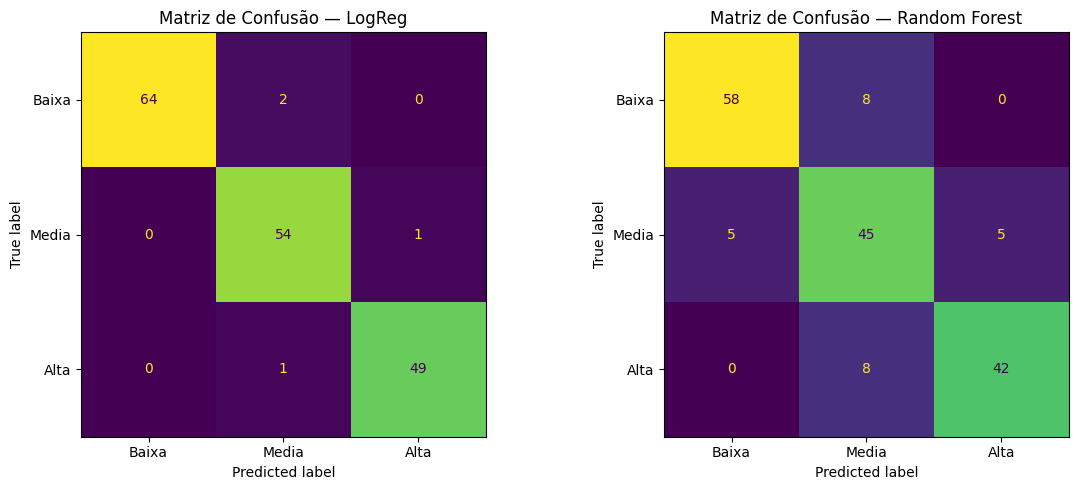

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["Baixa", "Media", "Alta"]

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_lr, display_labels=labels).plot(ax=ax[0], cmap="viridis", colorbar=False)
ax[0].set_title("Matriz de Confusão — LogReg")

ConfusionMatrixDisplay(cm_rf, display_labels=labels).plot(ax=ax[1], cmap="viridis", colorbar=False)
ax[1].set_title("Matriz de Confusão — Random Forest")

plt.tight_layout()
plt.show()


A avaliação no conjunto de teste confirma o melhor desempenho da Regressão Logística em relação ao Random Forest. Além das métricas globais superiores, observou-se padrão de erros concentrado entre classes adjacentes, reforçando a adequação de um modelo linear e mais interpretável para este conjunto de variáveis agregadas em nível municipal.

## Interpretabilidade do modelo

In [125]:
X_train = treino[vars_final]
y_train = treino["prioridade"]

pipe_final.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tx_obitos_icsap_1000',
                                                   'tx_obitos_total_1000',
                                                   'ivs', 'idhm', 'i_gini',
                                                   'ubs_por_10000', 'espvida',
                                                   'densidade_demografica_pop_km2_2022'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

In [126]:
import pandas as pd

logreg = pipe_final.named_steps["model"]  # LogisticRegression
classes = logreg.classes_

coef_df = pd.DataFrame(
    logreg.coef_,
    columns=vars_final,
    index=classes
)

coef_df

,tx_obitos_icsap_1000,tx_obitos_total_1000,ivs,idhm,i_gini,ubs_por_10000,espvida,densidade_demografica_pop_km2_2022
Alta,3.980006,2.041059,3.430941,-2.666782,1.384956,-1.697164,-0.064085,-0.208500
Baixa,-4.013411,-2.199261,-3.521173,2.729016,-1.341201,1.901296,0.057678,0.283425
Media,0.033405,0.158202,0.090233,-0.062234,-0.043755,-0.204132,0.006407,-0.074925


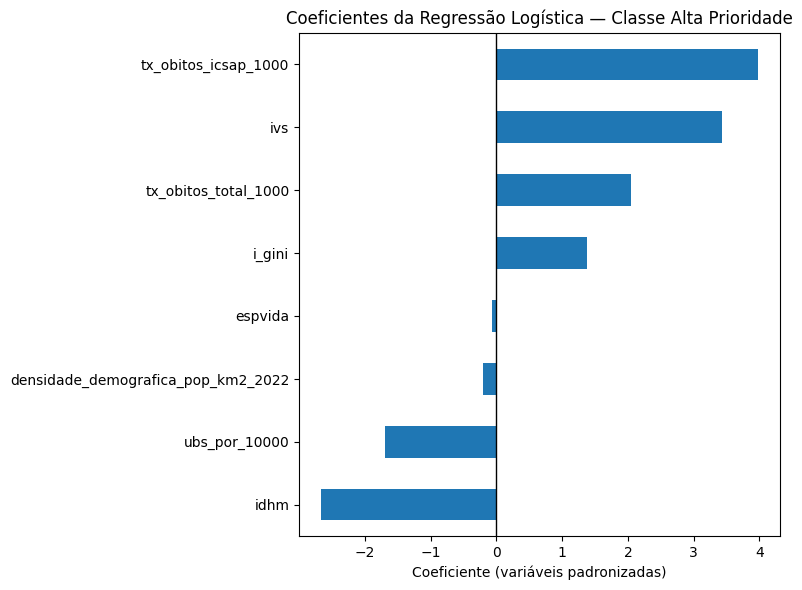

In [127]:
import matplotlib.pyplot as plt

coef_alta = coef_df.loc["Alta"].sort_values()

plt.figure(figsize=(8, 6))
coef_alta.plot(kind="barh")
plt.axvline(0, color="black", linewidth=1)
plt.title("Coeficientes da Regressão Logística — Classe Alta Prioridade")
plt.xlabel("Coeficiente (variáveis padronizadas)")
plt.tight_layout()
plt.show()

In [128]:
import numpy as np

odds_ratio_alta = np.exp(coef_df.loc["Alta"]).sort_values(ascending=False)
odds_ratio_alta

tx_obitos_icsap_1000                  53.517361
ivs                                   30.905699
tx_obitos_total_1000                   7.698760
i_gini                                 3.994652
espvida                                0.937925
densidade_demografica_pop_km2_2022     0.811801
ubs_por_10000                          0.183202
idhm                                   0.069475
Name: Alta, dtype: float64

Odds ratio refere-se a aumento de 1 desvio-padrão na variável, e não 1 unidade original.

In [129]:
top_pos = coef_df.loc["Alta"].sort_values(ascending=False).head(5)
top_neg = coef_df.loc["Alta"].sort_values(ascending=True).head(5)

pd.DataFrame({
    "Top + (aumenta Alta)": top_pos,
    "Top - (reduz Alta)": top_neg
})

,Top + (aumenta Alta),Top - (reduz Alta)
densidade_demografica_pop_km2_2022,NaN,-0.208500
espvida,-0.064085,-0.064085
i_gini,1.384956,1.384956
idhm,NaN,-2.666782
ivs,3.430941,NaN
tx_obitos_icsap_1000,3.980006,NaN
tx_obitos_total_1000,2.041059,NaN
ubs_por_10000,NaN,-1.697164


## Resultados Aplicados: Ranking e Mapa

In [147]:
df_result = df.copy()

# predizer classe
df_result["prioridade_predita"] = pipe_final.predict(df_result[vars_final])

# probabilidade por classe
proba = pipe_final.predict_proba(df_result[vars_final])
classes = pipe_final.named_steps["model"].classes_
idx_alta = list(classes).index("Alta")

df_result["prob_alta_prioridade"] = proba[:, idx_alta]

In [148]:
# 1) Ler a base com nomes dos municípios
df_mun = pd.read_excel("caract_municipio_mg_final.xlsx")

# 2) Garantir que os códigos estão como string com 7 dígitos
df_mun["municipio"] = df_mun["municipio"].astype(str).str.zfill(7)
df_result["IBGE7"] = df_result["IBGE7"].astype(str).str.zfill(7)

# 3) Selecionar apenas as colunas necessárias
df_mun_aux = df_mun[["municipio", "nome_municipio_uf"]].copy()

# 4) Fazer o merge (chaves com nomes diferentes)
df_result = df_result.merge(
    df_mun_aux,
    left_on="IBGE7",
    right_on="municipio",
    how="left"
)

# 5) (Opcional) remover coluna duplicada de código
df_result = df_result.drop(columns=["municipio"])

# 6) Checagem obrigatória
print("Nomes ausentes:", df_result["nome_municipio_uf"].isna().sum())



Nomes ausentes: 0


In [149]:
ordem_prioridade = {"Alta": 1, "Media": 2, "Baixa": 3}

df_rank = df_result.copy()
df_rank["ordem_prioridade"] = df_rank["prioridade_predita"].map(ordem_prioridade)

df_rank = df_rank.sort_values(
    by=["ordem_prioridade", "score_prioridade"],
    ascending=[True, False]
)

In [150]:
colunas_export = [
    "IBGE7",
    "nome_municipio_uf",
    "prioridade_predita",
    "prob_alta_prioridade",
    "score_prioridade",
    "tx_obitos_icsap_1000",
    "tx_obitos_total_1000",
    "ivs",
    "idhm",
    "i_gini",
    "ubs_por_10000",
    "espvida",
    "densidade_demografica_pop_km2_2022"
]

tabela_municipios = df_rank[colunas_export].round(4)
tabela_municipios.head(10)

,IBGE7,nome_municipio_uf,prioridade_predita,prob_alta_prioridade,score_prioridade,tx_obitos_icsap_1000,tx_obitos_total_1000,ivs,idhm,i_gini,ubs_por_10000,espvida,densidade_demografica_pop_km2_2022
717,3161601,São Geraldo da Piedade (MG),Alta,1.0,0.6660,0.6409,0.5653,0.7313,0.2500,0.5000,0.2520,71.43,21.70
641,3155108,Rio do Prado (MG),Alta,1.0,0.6639,0.9159,0.4287,0.6384,0.2676,0.3696,0.3591,73.40,9.67
583,3150000,Pescador (MG),Alta,1.0,0.6613,0.9916,0.5944,0.4141,0.4472,0.4348,0.2333,74.85,11.25
141,3113008,Caraí (MG),Alta,1.0,0.6532,0.5364,0.4565,0.7293,0.1021,0.4565,0.1705,71.88,15.73
26,3102506,Amparo do Serra (MG),Alta,1.0,0.6503,0.7961,0.8497,0.4000,0.3944,0.3043,0.1834,73.63,33.34
777,3166105,Senhora do Porto (MG),Alta,1.0,0.6440,0.6451,0.7526,0.4848,0.1268,0.3261,0.2716,73.10,8.04
642,3155207,Rio Espera (MG),Alta,1.0,0.6398,0.7107,0.6006,0.5515,0.2570,0.3478,0.2302,73.03,22.75
541,3146305,Padre Paraíso (MG),Alta,1.0,0.6366,0.6440,0.4284,0.6566,0.2359,0.4783,0.2163,72.83,31.84
769,3165552,Setubinha (MG),Alta,1.0,0.6352,0.3493,0.1993,1.0000,0.0458,0.5000,0.1680,69.60,18.55
61,3105707,Barra Longa (MG),Alta,1.0,0.6302,0.7056,0.5653,0.6424,0.3345,0.3478,0.2940,74.36,14.77


In [151]:
tabela_municipios.to_excel("ranking_prioridade_ubs_mg.xlsx", index=False)
tabela_municipios.to_csv("ranking_prioridade_ubs_mg.csv", index=False, sep=";")

In [157]:
import geopandas as gpd

gdf_mg = gpd.read_file("Dados/MG_Municipios_2024.shp")

gdf_mg["IBGE7"] = gdf_mg["CD_MUN"].astype(str).str.zfill(7)

df_plot = df_result.copy()
df_plot["IBGE7"] = df_plot["IBGE7"].astype(str).str.zfill(7)


In [155]:
gdf_plot = gdf_mg.merge(
    df_plot[["IBGE7", "prioridade_predita"]],
    on="IBGE7",
    how="left"
)

print("Sem prioridade_predita:", gdf_plot["prioridade_predita"].isna().sum())


Sem prioridade_predita: 0


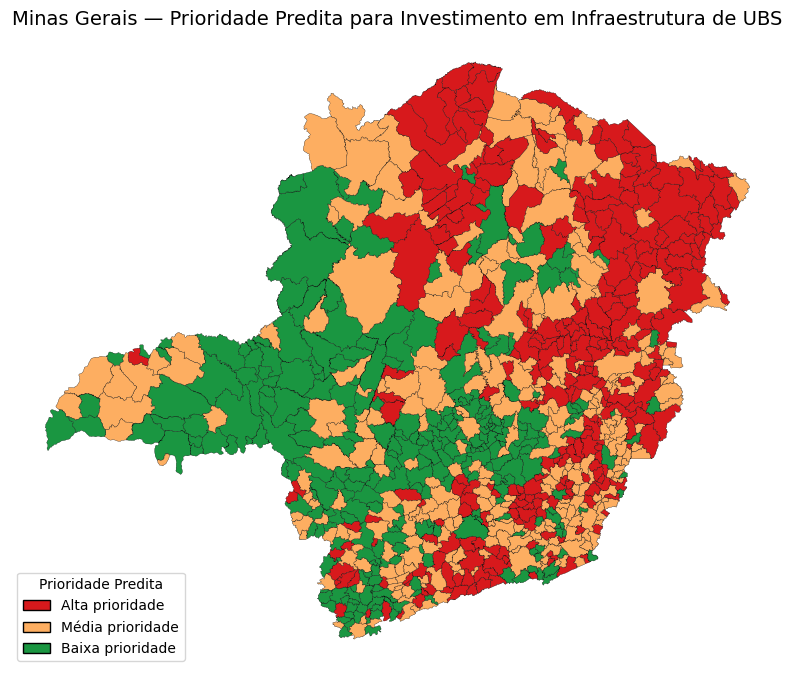

In [156]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

cores = {
    "Alta":  "#d7191c",   # vermelho
    "Media": "#fdae61",   # amarelo
    "Baixa": "#1a9641"    # verde
}

gdf_plot["cor"] = gdf_plot["prioridade_predita"].map(cores)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_plot.plot(
    ax=ax,
    color=gdf_plot["cor"],
    linewidth=0.2,
    edgecolor="black"
)

ax.set_title(
    "Minas Gerais — Prioridade Predita para Investimento em Infraestrutura de UBS",
    fontsize=14
)
ax.set_axis_off()

legenda = [
    Patch(facecolor=cores["Alta"], edgecolor="black", label="Alta prioridade"),
    Patch(facecolor=cores["Media"], edgecolor="black", label="Média prioridade"),
    Patch(facecolor=cores["Baixa"], edgecolor="black", label="Baixa prioridade"),
]
ax.legend(handles=legenda, title="Prioridade Predita", loc="lower left")

plt.show()